# Sentiment Analysis using BERT

CODE ALMOST ALL FROM: https://www.kaggle.com/code/prakharrathi25/sentiment-analysis-using-bert
THE DATASET I USED: https://github.com/dxlabskku/Mental-Health/blob/main/data/twitter_English.csv

### Import Libraries and Set the intial variables

In [36]:
!pip install transformers

In [37]:
# Import necessary libraries
import numpy as np
import pandas as pd
import seaborn as sns
from pylab import rcParams
import matplotlib.pyplot as plt
from matplotlib import rc
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from collections import defaultdict
from textwrap import wrap

# Torch ML libraries
import transformers
from transformers import BertModel, BertTokenizer, AdamW, get_linear_schedule_with_warmup
import torch
from torch import nn, optim
from torch.utils.data import Dataset, DataLoader

# Misc.
import warnings
warnings.filterwarnings('ignore')

In [38]:
# Set intial variables and constants
%config InlineBackend.figure_format='retina'

# Graph Designs
sns.set(style='whitegrid', palette='muted', font_scale=1.2)
HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]
sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))
rcParams['figure.figsize'] = 12, 8

# Random seed for reproducibilty
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)

# Set GPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [39]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

### Load the data

In [81]:
df = pd.read_csv("/content/depressive_tweets_processed.csv",sep = '|', header = None, usecols = range(0,9))
df.columns = [3, "date", "time", "time-zone", "user", "tweet", 0, 1, 2]
df = df.drop([0, 1, 2, 3, "time-zone", "time", "date", "user"], axis = 1)
df['label'] = [1] * len(df['tweet']) # 1 cause these are all depressed tweets
df2_d = pd.read_csv("/content/d_tweets.csv")
df2_d = df2_d[["tweet"]]
df2_d['label'] = [1] * len(df2_d['tweet'])

df2_nd = pd.read_csv("/content/non_d_tweets.csv")
df2_nd = df2_nd[["tweet"]]
df2_nd['label'] = [0] * len(df2_nd['tweet'])
print(len(df2_nd['label']))
df = pd.concat([df2_d, df2_nd, df])
df.reset_index(inplace = True)
df['tweet'] = df['tweet'].astype(str)

4809


We can see that the most relevant column for us is content and replyContent and the score as well.

In [82]:
df.iloc[4].tweet

"i don't think anyone really understands how tiring it is to act okay and always be the 'strong' one when in reality you're close to the edge."

In [43]:
# Let's have a look at the class balance.
sns.countplot(df.label)
plt.xlabel('review score');

KeyboardInterrupt: 

Error in callback <function _draw_all_if_interactive at 0x7f59d0993eb0> (for post_execute):


KeyboardInterrupt: 

Error in callback <function flush_figures at 0x7f59d0993130> (for post_execute):


KeyboardInterrupt: 

We can see that we have more positive classes than negative and low number of neutral class. I have kept neutral less to focus more on positive and negative classes. Let's allot classes based on scores now.

* 0 - negative
* 1 - neutral
* 2 - positive

[Text(0, 0, 'not depressed'),
 Text(1, 0, 'depressed'),
 Text(2, 0, ''),
 Text(3, 0, ''),
 Text(4, 0, ''),
 Text(5, 0, ''),
 Text(6, 0, ''),
 Text(7, 0, ''),
 Text(8, 0, ''),
 Text(9, 0, ''),
 Text(10, 0, ''),
 Text(11, 0, ''),
 Text(12, 0, ''),
 Text(13, 0, ''),
 Text(14, 0, ''),
 Text(15, 0, ''),
 Text(16, 0, ''),
 Text(17, 0, ''),
 Text(18, 0, ''),
 Text(19, 0, ''),
 Text(20, 0, ''),
 Text(21, 0, ''),
 Text(22, 0, ''),
 Text(23, 0, ''),
 Text(24, 0, ''),
 Text(25, 0, ''),
 Text(26, 0, ''),
 Text(27, 0, ''),
 Text(28, 0, ''),
 Text(29, 0, ''),
 Text(30, 0, ''),
 Text(31, 0, ''),
 Text(32, 0, ''),
 Text(33, 0, ''),
 Text(34, 0, ''),
 Text(35, 0, ''),
 Text(36, 0, ''),
 Text(37, 0, ''),
 Text(38, 0, ''),
 Text(39, 0, ''),
 Text(40, 0, ''),
 Text(41, 0, ''),
 Text(42, 0, ''),
 Text(43, 0, ''),
 Text(44, 0, ''),
 Text(45, 0, ''),
 Text(46, 0, ''),
 Text(47, 0, ''),
 Text(48, 0, ''),
 Text(49, 0, ''),
 Text(50, 0, ''),
 Text(51, 0, ''),
 Text(52, 0, ''),
 Text(53, 0, ''),
 Text(54, 0, '')

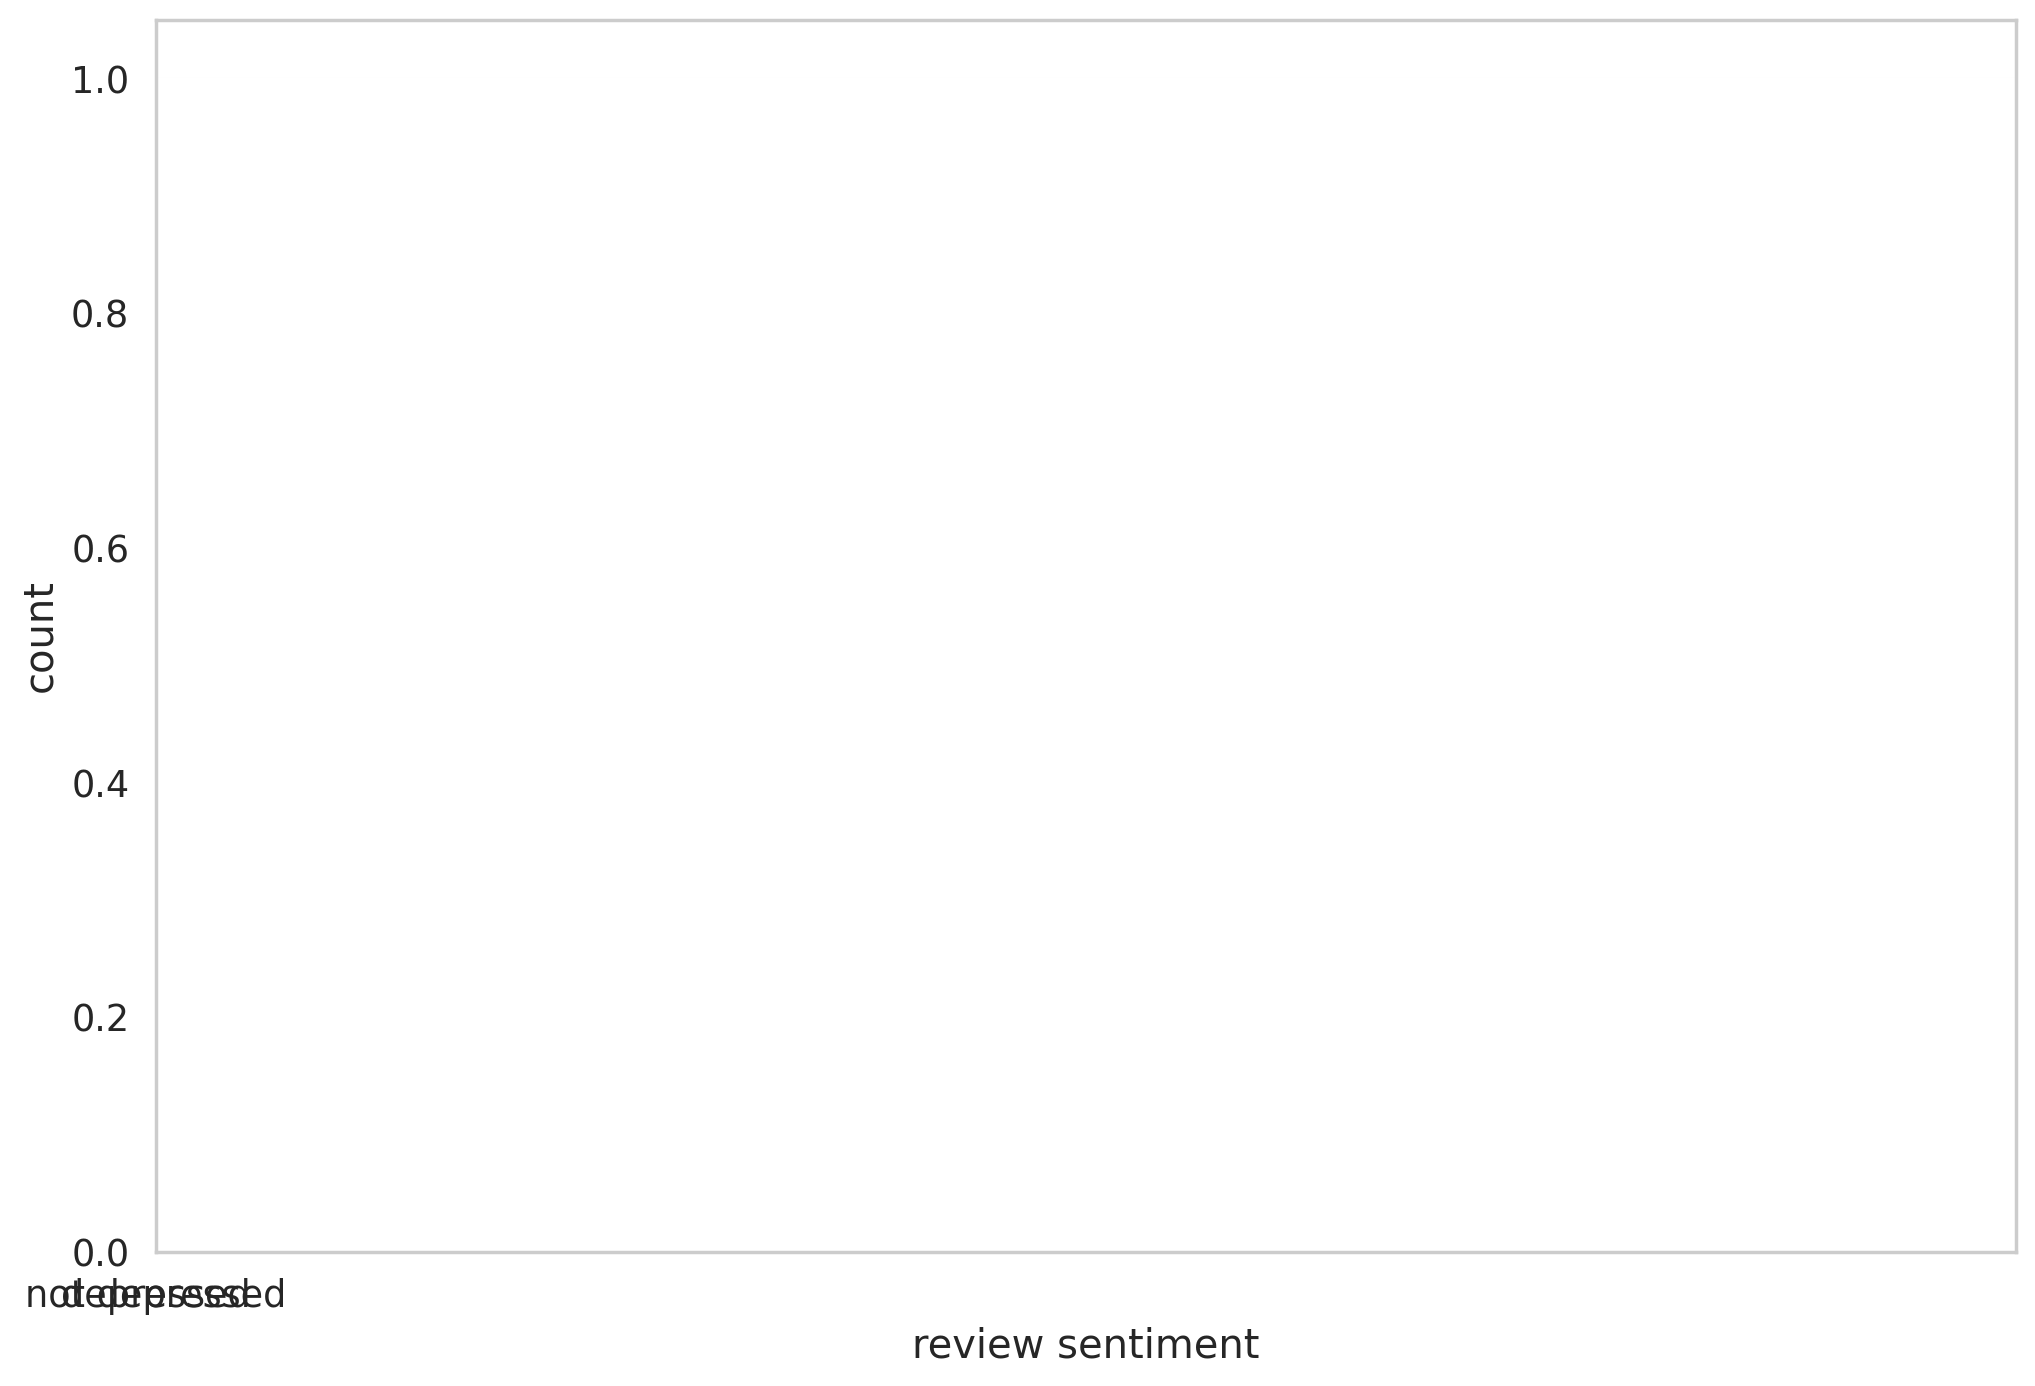

In [44]:
# Plot the distribution
class_names = ['not depressed', 'depressed']
ax = sns.countplot(df.label)
plt.xlabel('review sentiment')
ax.set_xticklabels(class_names)

## Data Preprocessing

Machine Learning models don’t work with raw text. You need to convert text to numerical representation. BERT requires even more attention when it comes to this representation.

Here are the requirements:

* Add special tokens to separate sentences and do classification
* Pass sequences of constant length (introduce padding)
* Create array of 0s (pad token) and 1s (real token) called attention mask

BERT offers a few model architectures and I will be using one of them combined with manual preprocessing. I am using the cased version which considers GREAT and great to be to different entities and BAD might be given more focus than bad.  

The tokenizer will break the sentence into words and give numerical values to each word.

In [83]:
# Set the model name
MODEL_NAME = 'bert-base-cased'

# Build a BERT based tokenizer
tokenizer = BertTokenizer.from_pretrained(MODEL_NAME, force_download=True)

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/213k [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/436k [00:00<?, ?B/s]

In [84]:
# Some of the common BERT tokens
print(tokenizer.sep_token, tokenizer.sep_token_id) # marker for ending of a sentence
print(tokenizer.cls_token, tokenizer.cls_token_id) # start of each sentence, so BERT knows we’re doing classification
print(tokenizer.pad_token, tokenizer.pad_token_id) # special token for padding
print(tokenizer.unk_token, tokenizer.unk_token_id) # tokens not found in training set

[SEP] 102
[CLS] 101
[PAD] 0
[UNK] 100


BERT works with fixed-length sequences. We’ll use a simple strategy to choose the max length. Let’s store the token length of each review.

In [85]:
# Store length of each review
token_lens = []

# Iterate through the content slide
for txt in df.tweet:
    tokens = tokenizer.encode(txt, max_length=512)
    token_lens.append(len(tokens))


Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


Text(0.5, 0, 'Token count')

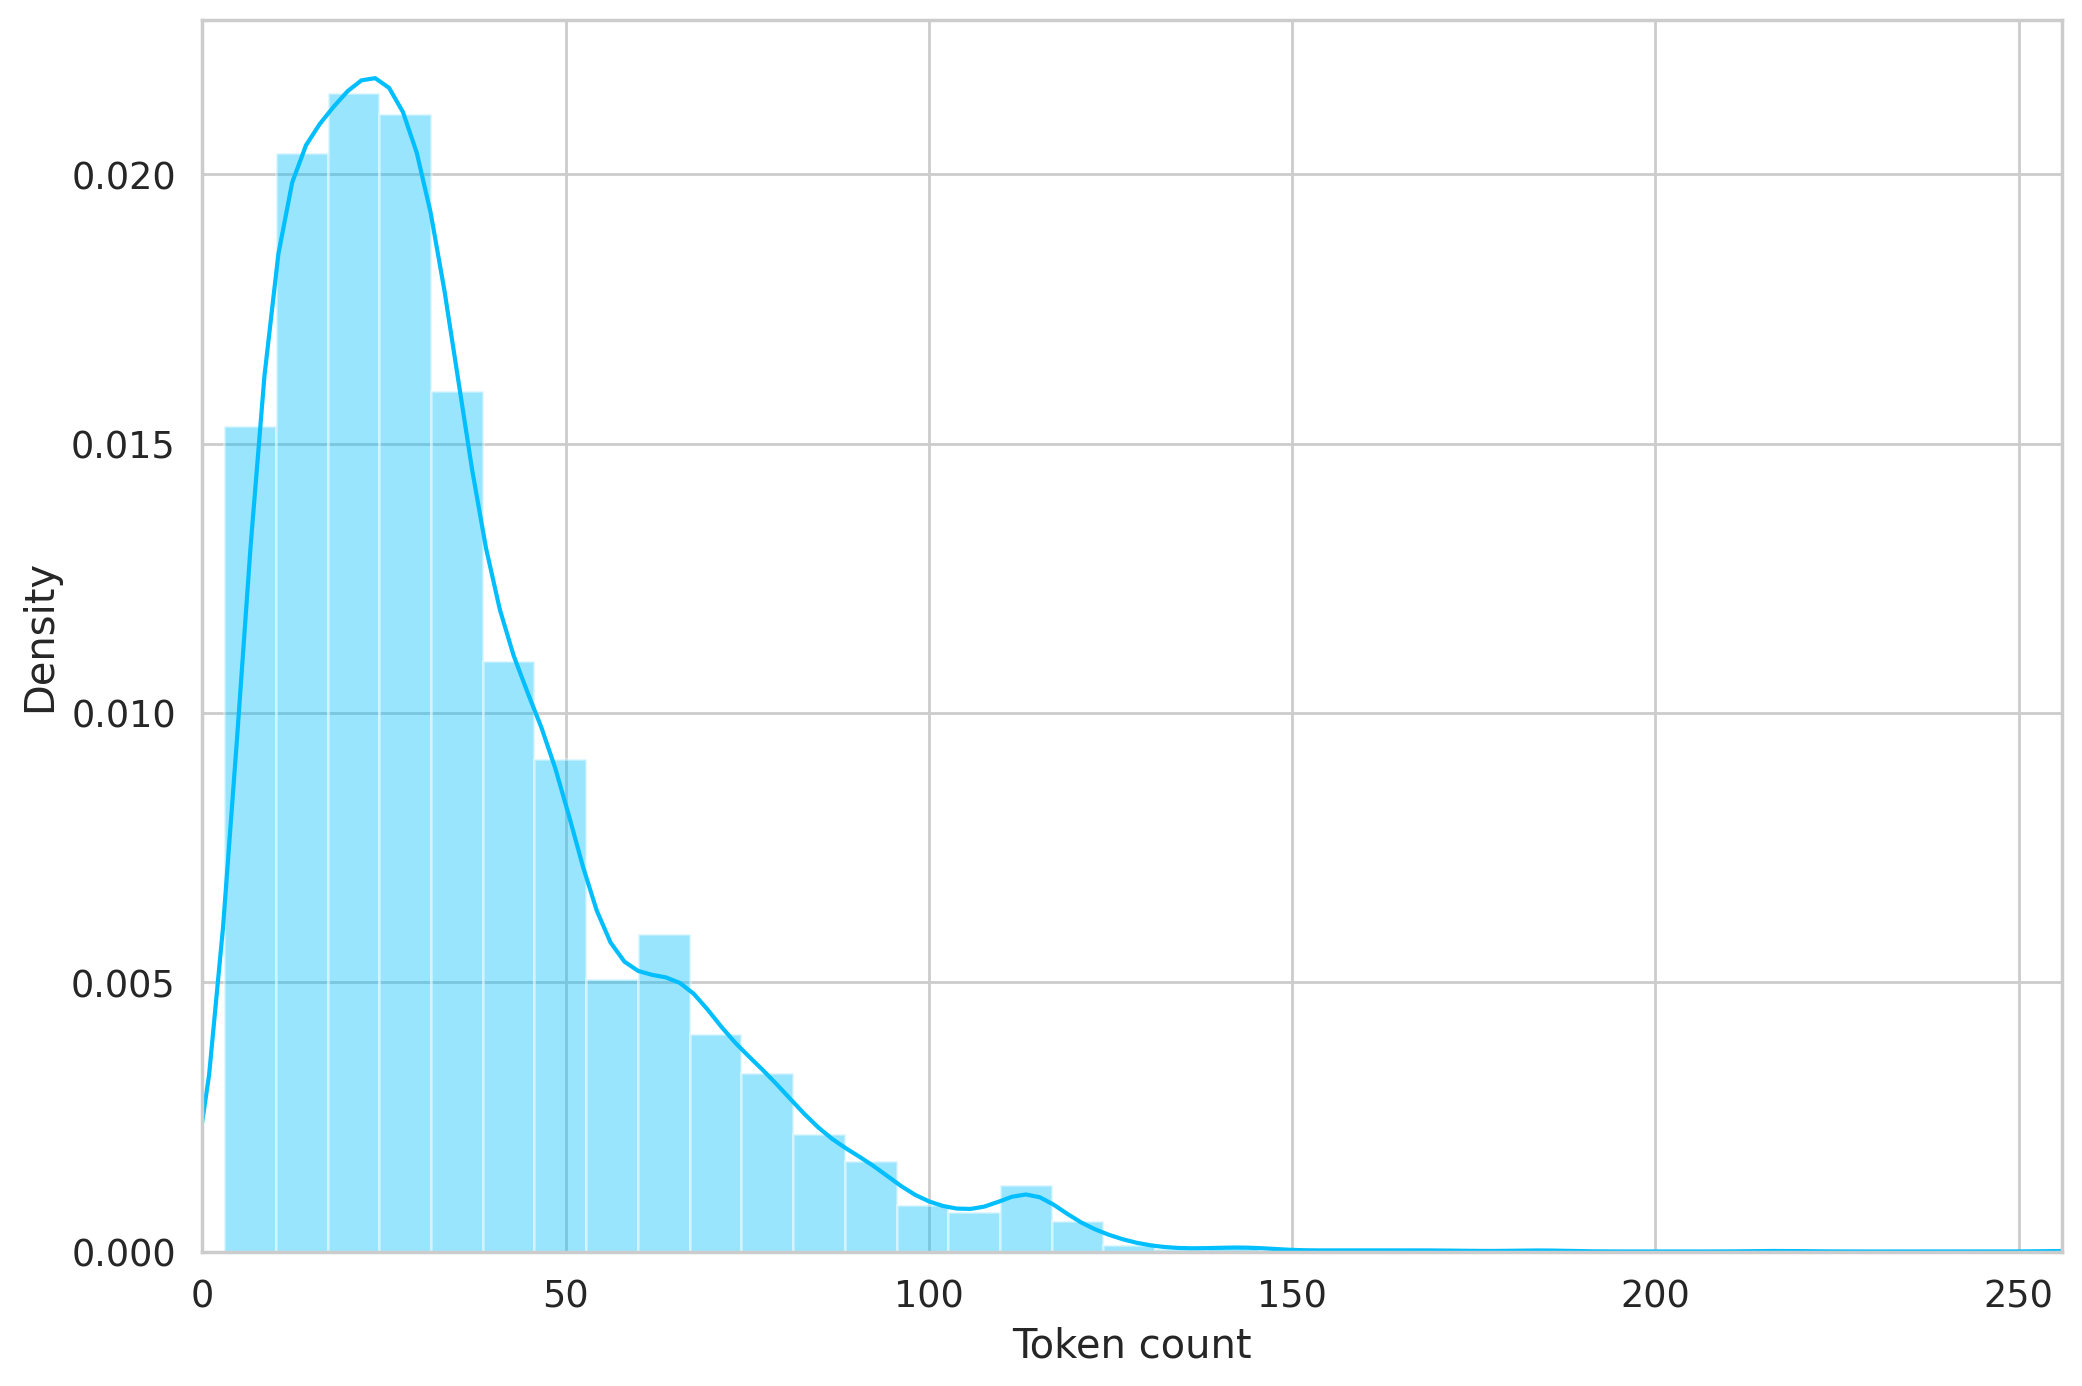

In [86]:
# plot the distribution of review lengths
sns.distplot(token_lens)
plt.xlim([0, 256]);
plt.xlabel('Token count')

Most of the reviews seem to contain less than 120 tokens, but we’ll be on the safe side and choose a maximum length of 160.

In [87]:
MAX_LEN = 160

### Preparing Torch Dataset

To enter data into a PyTorch, we need a more robust data generator class. We will return the review text as well to validate our predictions easily.

In [88]:
class GPReviewDataset(Dataset):
    # Constructor Function
    def __init__(self, reviews, targets, tokenizer, max_len):
        self.reviews = reviews
        self.targets = targets
        self.tokenizer = tokenizer
        self.max_len = max_len

    # Length magic method
    def __len__(self):
        return len(self.reviews)

    # get item magic method
    def __getitem__(self, item):
        review = str(self.reviews[item])
        target = self.targets[item]

        # Encoded format to be returned
        encoding = self.tokenizer.encode_plus(
            review,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            pad_to_max_length=True,
            return_attention_mask=True,
            return_tensors='pt',
        )

        return {
            'review_text': review,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'targets': torch.tensor(target, dtype=torch.long)
        }

Create a 80% train data and 10% test and 10% validation data

In [89]:
df_train, df_test = train_test_split(df, test_size=0.2, random_state=RANDOM_SEED)
df_val, df_test = train_test_split(df_test, test_size=0.5, random_state=RANDOM_SEED)

print(df_train.shape, df_val.shape, df_test.shape)

(8520, 3) (1065, 3) (1065, 3)


Create a dataloader to release data in batches.

In [90]:
def create_data_loader(df, tokenizer, max_len, batch_size):
    ds = GPReviewDataset(
        reviews=df.tweet.to_numpy(),
        targets=df.label.to_numpy(),
        tokenizer=tokenizer,
        max_len=max_len
    )

    return DataLoader(
        ds,
        batch_size=batch_size,
        num_workers=0
    )

In [91]:
# Create train, test and val data loaders
BATCH_SIZE = 16
train_data_loader = create_data_loader(df_train, tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = create_data_loader(df_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = create_data_loader(df_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [92]:
# Examples
data = next(iter(train_data_loader))
print(data.keys())

print(data['input_ids'].shape)
print(data['attention_mask'].shape)
print(data['targets'].shape)

dict_keys(['review_text', 'input_ids', 'attention_mask', 'targets'])
torch.Size([16, 160])
torch.Size([16, 160])
torch.Size([16])


In [93]:
data

{'review_text': ['i wonder if people hate me more or less than i think they do',
  'At some point, the internet is going to run out of space for your Star Wars opinions.',
  'I know someone that took 3 years to get over depression',
  'These 5 principles, if applied daily, will reap positive spiritual &amp; physical results. They are Truth, Order, Love, Faith &amp; Patience.',
  'Someone parked in my reserved spot at home. Eating ice cream and killing peeps on the Rift until we feel better. 😤   https://t.co/tgfcevFXgZ  https://t.co/xOyW5Y9sya',
  'this coronavirus bullshit has cancelled my therapy sessions for weeks. i’m dying',
  'This is bothering me. Today the Pogchamps tournament featured amazing players: @ConnorEatsPants  @AustinOnTwitter  @tfblade  @dogdog  @TSM_ZexRow  When they played their looks were NOT apart of the conversation. Why did that change when I played.  Do better twitch chat. Jesus.',
  'Midnight overthinking.',
  "We're all smiles and HAPPY NEWS at  https://t.co/

## Sentiment Classification with BERT and Hugging Face

We’ll use the basic BertModel and build our sentiment classifier on top of it. Let’s load the model

In [94]:
# Load the basic BERT model
bert_model = BertModel.from_pretrained(MODEL_NAME)

In [95]:
# Build the Sentiment Classifier class
class SentimentClassifier(nn.Module):

    # Constructor class
    def __init__(self, n_classes):
        super(SentimentClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(MODEL_NAME)
        self.drop = nn.Dropout(p=0.3)
        self.out = nn.Linear(self.bert.config.hidden_size, n_classes)

    # Forward propagaion class
    def forward(self, input_ids, attention_mask):
        _, pooled_output = self.bert(
          input_ids=input_ids,
          attention_mask=attention_mask,
          return_dict=False
        )
        #  Add a dropout layer
        output = self.drop(pooled_output)
        return self.out(output)

We use a dropout layer for some regularization and a fully-connected layer for our output. We are returning the raw output of the last layer since that is required for the cross-entropy loss function in PyTorch to work. Create an instance and move it to the GPU

In [96]:
# Instantiate the model and move to classifier
model = SentimentClassifier(len(class_names))
model = model.to(device)

#### Model Characterstics

In [97]:
# Number of hidden units
print(bert_model.config.hidden_size)

768


### Training Phase

we’ll use the AdamW optimizer provided by Hugging Face. It corrects weight decay. We’ll also use a linear scheduler with no warmup

In [98]:
# Number of iterations
EPOCHS = 4

# Optimizer Adam
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)

total_steps = len(train_data_loader) * EPOCHS

scheduler = get_linear_schedule_with_warmup(
    optimizer,
    num_warmup_steps=0,
    num_training_steps=total_steps
)

# Set the loss function
loss_fn = nn.CrossEntropyLoss().to(device)

In [99]:
# Function for a single training iteration
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, n_examples):
    model = model.train()
    losses = []
    correct_predictions = 0

    for d in data_loader:
        input_ids = d["input_ids"].to(device)
        attention_mask = d["attention_mask"].to(device)
        targets = d["targets"].to(device)

        outputs = model(
            input_ids=input_ids,
            attention_mask=attention_mask,
        )

        _, preds = torch.max(outputs, dim=1)
        loss = loss_fn(outputs, targets)
        correct_predictions += torch.sum(preds == targets)
        losses.append(loss.item())

        # Backward prop
        loss.backward()

        # Gradient Descent
        nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double() / n_examples, np.mean(losses)

Write a function to evaluate model performance

In [100]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
    model = model.eval()

    losses = []
    correct_predictions = 0

    with torch.no_grad():
        for d in data_loader:
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get model ouptuts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )

            _, preds = torch.max(outputs, dim=1)
            loss = loss_fn(outputs, targets)

            correct_predictions += torch.sum(preds == targets)
            losses.append(loss.item())

    return correct_predictions.double() / n_examples, np.mean(losses)

Write the training Loop and store the best training state.

In [101]:
model

SentimentClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(28996, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, eleme

In [102]:
%%time

history = defaultdict(list)
best_accuracy = 0

for epoch in range(EPOCHS):

    # Show details
    print(f"Epoch {epoch + 1}/{EPOCHS}")
    print("-" * 10)

    train_acc, train_loss = train_epoch(
        model,
        train_data_loader,
        loss_fn,
        optimizer,
        device,
        scheduler,
        len(df_train)
    )

    print(f"Train loss {train_loss} accuracy {train_acc}")

    # Get model performance (accuracy and loss)
    val_acc, val_loss = eval_model(
        model,
        val_data_loader,
        loss_fn,
        device,
        len(df_val)
    )

    print(f"Val   loss {val_loss} accuracy {val_acc}")
    print()

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    # If we beat prev performance
    if val_acc > best_accuracy:
        torch.save(model.state_dict(), 'best_model_state.bin')
        best_accuracy = val_acc

Epoch 1/4
----------
Train loss 0.22591978557015582 accuracy 0.9193661971830985
Val   loss 0.13972709800895136 accuracy 0.9511737089201878

Epoch 2/4
----------
Train loss 0.09199984236818032 accuracy 0.9740610328638497
Val   loss 0.14903514435142973 accuracy 0.9624413145539906

Epoch 3/4
----------
Train loss 0.03337812789890122 accuracy 0.9916666666666667
Val   loss 0.1794159294261576 accuracy 0.9671361502347418

Epoch 4/4
----------
Train loss 0.015162655699292222 accuracy 0.9968309859154929
Val   loss 0.18787556431219746 accuracy 0.968075117370892

CPU times: user 10min 2s, sys: 4min 55s, total: 14min 57s
Wall time: 15min 32s


The above took a lot of time but it's finally working. Now, we can plot the training and validation accuracy.

In [103]:
history

defaultdict(list,
            {'train_acc': [tensor(0.9194, device='cuda:0', dtype=torch.float64),
              tensor(0.9741, device='cuda:0', dtype=torch.float64),
              tensor(0.9917, device='cuda:0', dtype=torch.float64),
              tensor(0.9968, device='cuda:0', dtype=torch.float64)],
             'train_loss': [0.22591978557015582,
              0.09199984236818032,
              0.03337812789890122,
              0.015162655699292222],
             'val_acc': [tensor(0.9512, device='cuda:0', dtype=torch.float64),
              tensor(0.9624, device='cuda:0', dtype=torch.float64),
              tensor(0.9671, device='cuda:0', dtype=torch.float64),
              tensor(0.9681, device='cuda:0', dtype=torch.float64)],
             'val_loss': [0.13972709800895136,
              0.14903514435142973,
              0.1794159294261576,
              0.18787556431219746]})

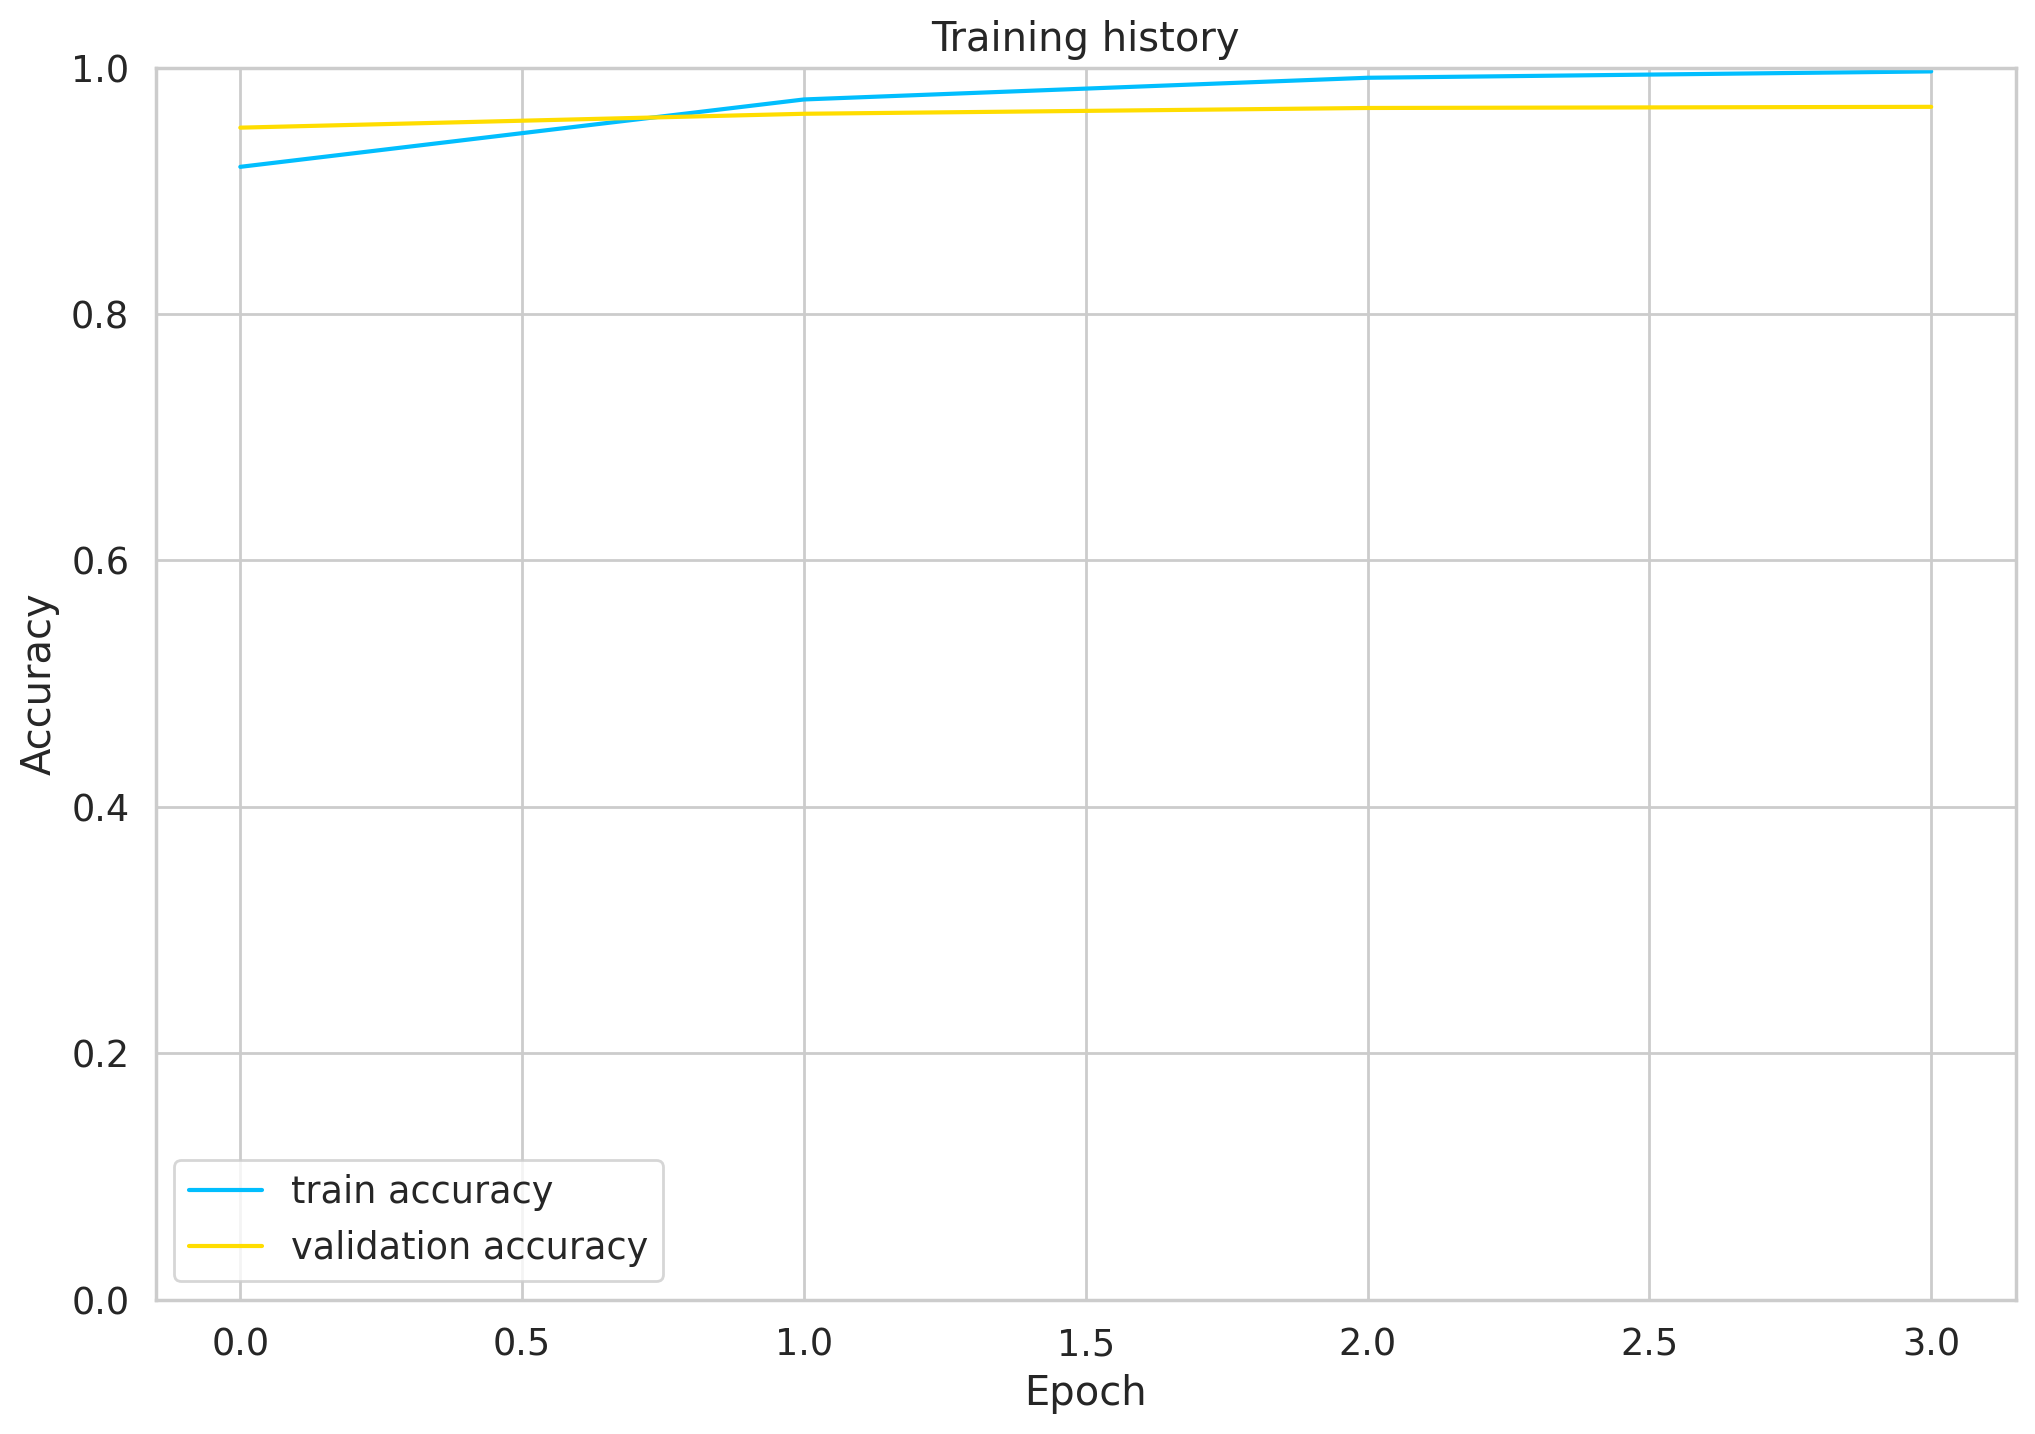

In [104]:
# Plot training and validation accuracy
plt.plot(list(map(lambda x: x.cpu(), history['train_acc'])), label='train accuracy')
plt.plot(list(map(lambda x: x.cpu(), history['val_acc'])), label='validation accuracy')

# Graph chars
plt.title('Training history')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend()
plt.ylim([0, 1]);

### Model Evaluation

In [105]:
test_acc, _ = eval_model(
  model,
  test_data_loader,
  loss_fn,
  device,
  len(df_test)
)

test_acc.item()

0.968075117370892

Define a helper function to get predictions from our models. This is similar to the evaluation function, except that we’re storing the text of the reviews and the predicted probabilities

In [106]:
def get_predictions(model, data_loader):
    model = model.eval()

    review_texts = []
    predictions = []
    prediction_probs = []
    real_values = []

    with torch.no_grad():
        for d in data_loader:
            texts = d["review_text"]
            input_ids = d["input_ids"].to(device)
            attention_mask = d["attention_mask"].to(device)
            targets = d["targets"].to(device)

            # Get outouts
            outputs = model(
                input_ids=input_ids,
                attention_mask=attention_mask
            )
            _, preds = torch.max(outputs, dim=1)

            review_texts.extend(texts)
            predictions.extend(preds)
            prediction_probs.extend(outputs)
            real_values.extend(targets)

    predictions = torch.stack(predictions).cpu()
    prediction_probs = torch.stack(prediction_probs).cpu()
    real_values = torch.stack(real_values).cpu()

    return review_texts, predictions, prediction_probs, real_values

In [107]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(
    model,
    test_data_loader
)

In [108]:
print(classification_report(y_test, y_pred, target_names=class_names))

               precision    recall  f1-score   support

not depressed       0.96      0.96      0.96       470
    depressed       0.97      0.97      0.97       595

     accuracy                           0.97      1065
    macro avg       0.97      0.97      0.97      1065
 weighted avg       0.97      0.97      0.97      1065



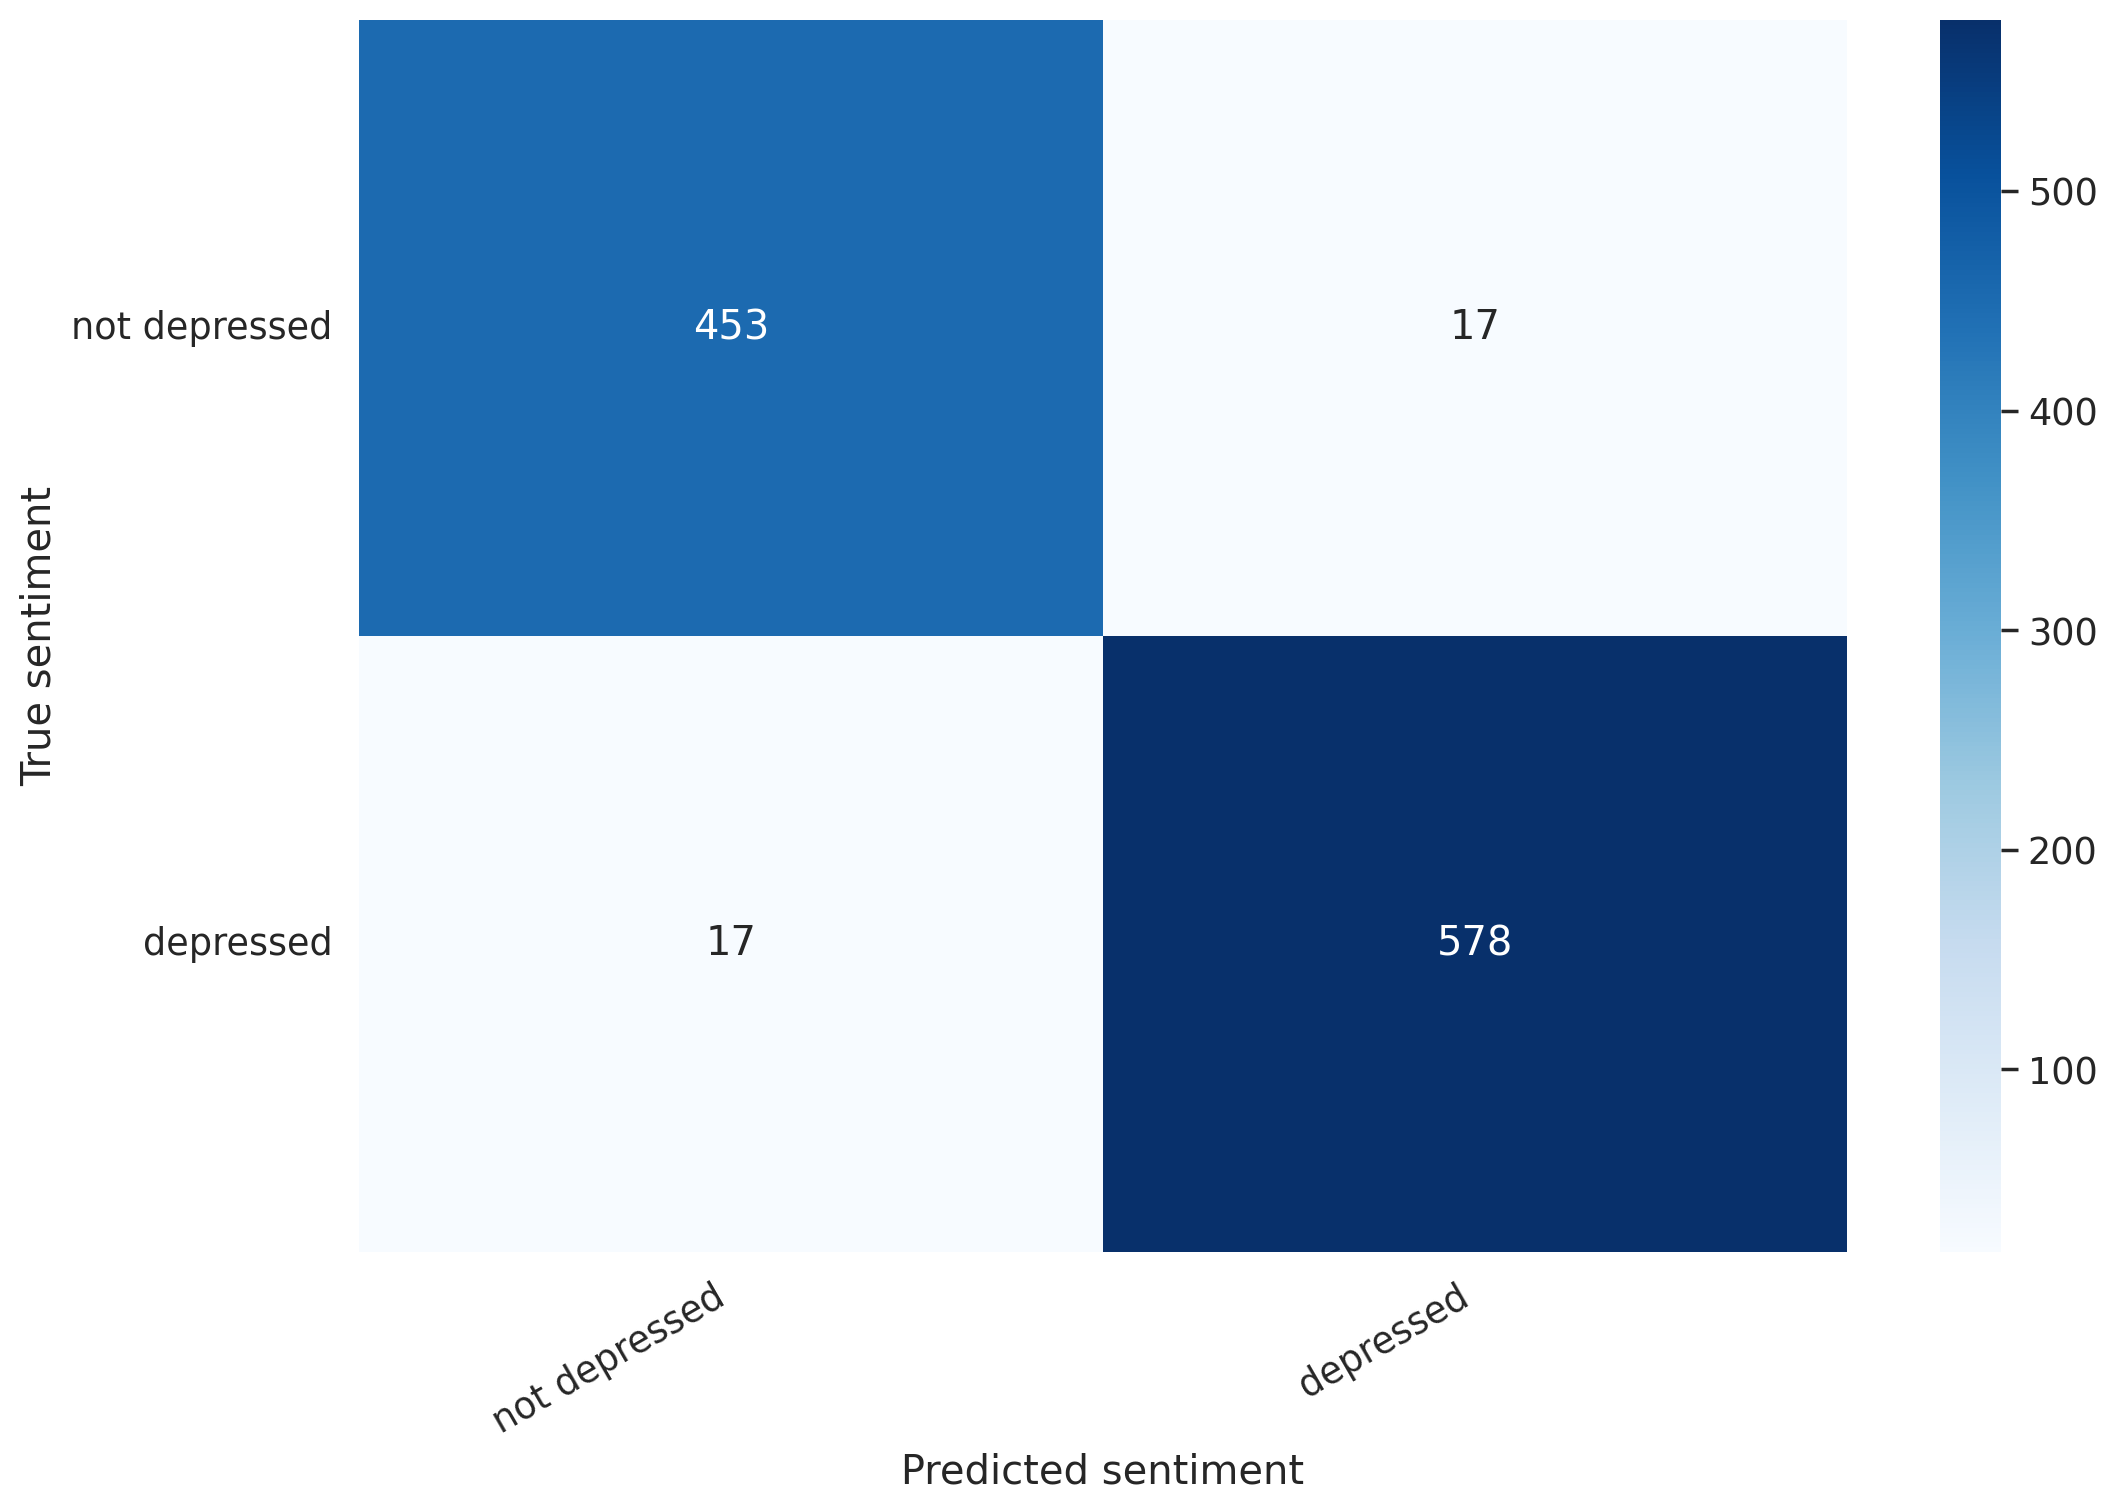

In [109]:
def show_confusion_matrix(confusion_matrix):
    hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
    hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
    hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
    plt.ylabel('True sentiment')
    plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=class_names, columns=class_names)
show_confusion_matrix(df_cm)

This confirms that our model is having difficulty classifying neutral reviews. It mistakes those for negative and positive at a roughly equal frequency.

That’s a good overview of the performance of our model.

## Predicting on raw text

In [110]:
review_text = "i hate life"

In [111]:
encoded_review = tokenizer.encode_plus(
    review_text,
    max_length=MAX_LEN,
    add_special_tokens=True,
    return_token_type_ids=False,
    pad_to_max_length=True,
    return_attention_mask=True,
    return_tensors='pt',
)

In [112]:
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = model(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: i hate life
Sentiment  : depressed
